In [36]:
import sys
sys.path.append('/Users/jihye/src/Ryu project/TSN-with-DQN/ddqn')

import pandas as pd
import simpy
# from node import Node 
import time
import tensorflow as tf
# from parameter import *
# from src import Src

## parameters

In [37]:
import os
from dataclasses import dataclass
import numpy as np
import random

# parameters
SINGLE_NODE = True  # False
OUTPUT_PORT = 1  # 2
SRCES = 8  # 8

# Reward
COMPLEX = False
BOUND = [0.5, 0.6]
W0 = [0.1, 0.03]
W1 = [0.01, 0.01]
W2 = [-0.6, -0.2]
W3 = -1
LM = 1.5
W = [0.6, 0.5]
# W = [0.5, 0.5] #? 왜 이게 더 잘되지
A = 0.01
RRW=3

# HOP_WEIGHT = 4
RANDOM_HOP = 4  # 0
RANDOM_CURRENT_DELAY_CC = 1  # originally 0 unit : T
RANDOM_CURRENT_DELAY_BE = [0, 2]  # originally [0,1] unit : T
PERIOD_CC = 2  # T
PERIOD_BE = 2
COMMAND_CONTROL = 40  # 40
BEST_EFFORT = 40  # 100
CC_DEADLINE = 7  # 5 (8 T), 10 least 5T, unit : T (if not, just multiply TIMESLOT_SIZE)
BE_DEADLINE = 7  # 50 ( 75 T ) 12
FIXED_SEQUENCE = False
FIRST_TRAIN = True
MAXSLOT_MODE = True
MAXSLOTS = 250  # 250
LEARNING_RATE = 0.001  # 0.0001
UPDATE = 400  # 500
EPSILON_DECAY = 0.9998  # 0.9998

# Save
# DATE = '0429_2'
FILENAME = './@0220/[15963]0.001464993692934513.h5'  # weight file name
WEIGHT_FILE = FILENAME

# RL agent
PRIORITY_QUEUE = 2
STATE = 2  # for simulation with different utilizations(periods), it has to be editted to 3
INPUT_SIZE = 4
# GCL_LENGTH = 3
OUTPUT_SIZE = 2
ALPHA = 0.1
INITIAL_ACTION = 0
ACTION_LIST = [0, 1]
ACTION_SIZE = len(ACTION_LIST)
BATCH = 64
EPSILON_MAX = 1
EPSILON_MIN = 0.01
DISCOUNT_FACTOR = 0.99

# Environment
MAX_EPISODE = 20000

CC_BYTE = 1500
BE_BYTE = 1500
TIMESLOT_SIZE = 0.6
BANDWIDTH = 20000  # bits per msec (20Mbps)
MAX_BURST = 12000
NODES = 9
MAX_REWARD = COMMAND_CONTROL * W[0] + BEST_EFFORT * W[1] + A * (COMMAND_CONTROL + BEST_EFFORT)
print(f'available maximum reward is {MAX_REWARD}')


import matplotlib.pyplot as plt


def save_result_plot(df):
    x = range(int(len(df['Episode'])))
    y = df['Score']
    plt.scatter(x, y, s=3)
    plt.savefig("./result/" + DATE + "/sum of reward.png", dpi=300)


# Functions
def max_burst():
    burst = BANDWIDTH * TIMESLOT_SIZE
    print("burst", burst)


def random_sequence():
    p1 = [[], []]
    p2 = [[], []]

    for i in range(COMMAND_CONTROL):
        hop = random.randint(0, RANDOM_HOP) + 1
        late = int(round(RANDOM_HOP / hop, 0))
        if hop == RANDOM_HOP + 1:
            late = 0
        cd = late + random.randint(0, RANDOM_CURRENT_DELAY_CC)
        p1[0].append(cd)
        p1[1].append(hop)

    for i in range(BEST_EFFORT):
        hop = random.randint(0, RANDOM_HOP) + 1
        late = int(round(RANDOM_HOP / hop, 0))
        if hop == RANDOM_HOP + 1:
            late = 0
        cd = late + random.randint(RANDOM_CURRENT_DELAY_BE[0], RANDOM_CURRENT_DELAY_BE[1])
        p2[0].append(cd)
        p2[1].append(hop)

    return p1, p2

def action_to_number(action):
    # action_ = action.flatten()
    bin_ = ''
    for a in action:
        bin_ += str(a)
    return ACTION_LIST.index(int(bin_, 2))


def number_to_action(action_id):  # number -> binary gcl code
    b_id = format(ACTION_LIST[action_id], '02b')
    action_ = np.array(list(map(int, b_id)))
    return action_

# packet structure

@dataclass
class Flow:
    src_: int = None
    dst_: int = None
    route_: list = None
    type_: int = None
    priority_: int = None
    num_: int = None
    deadline_: float = None
    generated_time_: float = None
    queueing_delay_: list = None
    current_delay_: float = None
    bits_: int = None
    met_: bool = None
    remain_hops_: int = None
    random_delay_: float = None


available maximum reward is 44.8


## Node_info modification

In [ ]:
# import simpy
# from parameter import *
# import warnings

# warnings.filterwarnings('ignore')


class Node:

    def __init__(self, node, env, start):
        self.node = node
        self.env = env
        self.start = start
        self.output_port = [[simpy.Store(env), simpy.Store(env)] for _ in range(OUTPUT_PORT)]
        # self.trans_queue = simpy.Store(env)
        self.action = [number_to_action(INITIAL_ACTION) for _ in range(OUTPUT_PORT)]
        self.port = -1
        self.r = [0, 0]
        self.state = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]

    def reset(self, env, start):  # initial state, new episode start
        self.env = env
        self.start = start
        self.r = [0, 0]
        self.output_port = [[simpy.Store(env), simpy.Store(env)] for _ in range(OUTPUT_PORT)]
        self.action = [number_to_action(INITIAL_ACTION) for _ in range(OUTPUT_PORT)]
        self.state = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]
        self.port = -1

    def schedulable(self):
        port = []

        for p in range(OUTPUT_PORT):
            q1 = int(self.state[p][0])
            q2 = int(self.state[p][2])
            # print (q1, q2)
            if not (q1 + q2 == (q1 or q2)):
                port.append(p)

        return port

    def link(self, output, scheduler='sp'):
        if scheduler == 'ddqn':
            for p in range(OUTPUT_PORT):
                yield self.env.process(self.ddqn_with_heuristic(output, p))
        elif scheduler == 'sp':
            for p in range(OUTPUT_PORT):
                yield self.env.process(self.strict_priority(output, p))
        elif scheduler == 'rr':
            for p in range(OUTPUT_PORT):
                yield self.env.process(self.round_robin(output, p))
        else:
            for p in range(OUTPUT_PORT):
                yield self.env.process(self.ddqn(output, p))

    def packet_in(self, pk):
        pt = 0
        if OUTPUT_PORT == 2:
            if self.port == -1:
                if pk.route_[1]:
                    self.port = pk.route_[1]
                else:
                    self.port = 0
            else:
                if self.port:
                    if not (pk.route_[1] == self.port):
                        pt = 1
        yield self.output_port[pt][pk.priority_ - 1].put(pk)

    def step(self):

        for p in range(OUTPUT_PORT):
            qlen, max_et = self.queue_info(p)
            state = np.zeros((PRIORITY_QUEUE, STATE))
            state[:, 0] = qlen
            state[:, 1] = max_et
            self.state[p] = state.flatten()

        return self.state

    def queue_info(self, port):
        l = [0, 0]  # state 1
        pod = [[], []]
        max_et = [0, 0]  # state 2
        for q in range(PRIORITY_QUEUE):
            flows = self.output_port[port][q].items
            if not flows:
                continue
            l[q] += len(flows)
            for i, flow in enumerate(flows):
                # The unit of estimated delay is T(timeslot)
                if SINGLE_NODE:
                    # et = flow.current_delay_ + flow.queueing_delay_ + flow.remain_hops_ + i
                    et = (flow.random_delay_ + flow.current_delay_ + flow.queueing_delay_ + flow.remain_hops_ + i)
                else:
                    # et = sum(flow.queueing_delay_) + flow.remain_hops_ + i
                    et = (flow.random_delay_ + sum(flow.queueing_delay_) + flow.remain_hops_ + i)
                pod_ = round(et/flow.deadline_,2)
                pod[q].append(pod_)
            max_et[q] = max(pod[q])
        return l, max_et

    def action_update(self, action, port):  # observe state and update GCL (cycle : 0.2*3)
        self.action[port] = number_to_action(action)

    def delay_for_packet_multinode(self, port):
        for q in range(PRIORITY_QUEUE):
            waiting = self.output_port[port][q].items
            for w in waiting:
                r = w.remain_hops_
                l = len(w.queueing_delay_)
                w.queueing_delay_[l - r - 1] += 1

    def delay_for_packet(self, port):
        for q in range(PRIORITY_QUEUE):
            waiting = self.output_port[port][q].items
            for w in waiting:
                w.queueing_delay_ += 1

    def ddqn_with_heuristic(self, output, port):

        priority1 = self.output_port[port][0].items
        priority2 = self.output_port[port][1].items

        if not priority1:
            # print("priority1 없음 - work conserving")
            if len(self.output_port[port][1].items):
                # print("priority2 보냄")
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                # if (port == 0) and (self.node == 2):
                #     print((self.env.now- self.start), "H - p2", fl.generated_time_, fl.queueing_delay_, fl.current_delay_)
                yield output.put(fl)

        elif not priority2:
            if len(self.output_port[port][0].items):
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                # if (port == 0) and (self.node == 2):
                #     print((self.env.now- self.start), "H - p1", fl.generated_time_, fl.queueing_delay_, fl.current_delay_)
                yield output.put(fl)
        else:
            if action_to_number(self.action[port]) == 0:
                # if len(self.output_port[port][0].items):
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                # if (port == 0) and (self.node == 2):
                #     print((self.env.now- self.start), "Q - p1", fl.generated_time_, fl.queueing_delay_, fl.current_delay_)
                yield output.put(fl)

            else:
                # if len(self.output_port[port][1].items):
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                # if (port == 0) and (self.node == 2):
                #     print((self.env.now- self.start), "Q - p2", fl.generated_time_, fl.queueing_delay_, fl.current_delay_)
                yield output.put(fl)

        if SINGLE_NODE:
            self.delay_for_packet(port)
        else:
            self.delay_for_packet_multinode(port)

    def ddqn(self, output, port):

        if action_to_number(self.action[port]) == 0:
            if len(self.output_port[port][0].items):
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)

        else:
            if len(self.output_port[port][1].items):
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)

        if SINGLE_NODE:
            self.delay_for_packet(port)
        else:
            self.delay_for_packet_multinode(port)

    
    def round_robin(self, output, port):
        
        priority1 = self.output_port[port][0].items
        priority2 = self.output_port[port][1].items

        # n = [1, 0]
        if not priority1: #work-conserving regardless of weight
            if len(self.output_port[port][1].items):
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)

        elif not priority2: #work-conserving regardless of weight
            if len(self.output_port[port][0].items):
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)
                
        else: #scheduling
            if self.r[1] == 1:
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                self.r = [0, 0]
                yield output.put(fl)
            
            elif self.r[0] < RRW:
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)
                if self.r[0] == RRW - 1:
                    self.r[1] = 1
                else:
                    self.r[0] += 1

        if SINGLE_NODE:
            self.delay_for_packet(port)
        else:
            self.delay_for_packet_multinode(port)

    def strict_priority(self, output, port):

        for q in range(PRIORITY_QUEUE):
            if len(self.output_port[port][q].items):
                fl = yield self.output_port[port][q].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)
                break

        if SINGLE_NODE:
            self.delay_for_packet(port)
        else:
            self.delay_for_packet_multinode(port)


In [ ]:
class Node_Old(Node):
    def __init__(self,node,env,start):
        super().__init__(node,env,start)
        
    def queue_info(self, port):
        l = [0, 0]  # state 1
        pod = [[], []]
        max_et = [0, 0]  # state 2
        for q in range(PRIORITY_QUEUE):
            flows = self.output_port[port][q].items
            if not flows:
                continue
            l[q] += len(flows)
            for i, flow in enumerate(flows):
                # The unit of estimated delay is T(timeslot)
                if SINGLE_NODE:
                    # et = flow.current_delay_ + flow.queueing_delay_ + flow.remain_hops_ + i
                    et = (flow.random_delay_ + flow.current_delay_ + flow.queueing_delay_ + flow.remain_hops_ + i)
                else:
                    # et = sum(flow.queueing_delay_) + flow.remain_hops_ + i
                    et = (flow.random_delay_ + sum(flow.queueing_delay_) + flow.remain_hops_ + i)
#                 pod_ = round(et/flow.deadline_,2)
                pod[q].append(et)
            max_et[q] = max(pod[q])
        return l, max_et
        

## Single node test simulation

In [ ]:

class Src:
    def __init__(self, src, start_time, seq):
        self.src = src
        self.cnt = 0
        self.episode_start_time = start_time
        self.sequence_p1, self.sequence_p2 = seq

    def reset(self, src, start_time):
        self.src = src
        self.cnt = 0
        self.episode_start_time = start_time

    def flow_generator(self, now, src, fnum):
        flow = Flow()

        flow.priority_ = 1

        if 1 < src < 8:  # must got to be editted when network topology being changed
            flow.priority_ = 2

        flow.src_ = src
        flow.dst_ = src
        flow.num_ = fnum
        flow.generated_time_ = now - self.episode_start_time
        flow.current_delay_ = 0
        flow.met_ = -1

        if SINGLE_NODE:
            flow.route_ = []
            flow.queueing_delay_ = 0

            if flow.priority_ == 1:
                flow.remain_hops_ = self.sequence_p1[1][fnum]
                flow.random_delay_ = self.sequence_p1[0][fnum]
                flow.deadline_ = CC_DEADLINE
                flow.bits_ = CC_BYTE * 8
            else:
                flow.remain_hops_ = self.sequence_p2[1][fnum]
                flow.random_delay_ = self.sequence_p2[0][fnum]
                flow.deadline_ = BE_DEADLINE
                flow.bits_ = BE_BYTE * 8

        else:
            flow.route_ = route[src - 1]
            h = len(route[src - 1]) - 1
            flow.remain_hops_ = h - 1
            flow.queueing_delay_ = [0 for _ in range(h)]  # nodes to be passed packts

            if flow.priority_ == 1:
                flow.deadline_ = CC_DEADLINE
                flow.random_delay_ = self.sequence_p1[0][fnum]
                flow.bits_ = CC_BYTE * 8

            else:
                flow.deadline_ = BE_DEADLINE
                flow.random_delay_ = self.sequence_p2[0][fnum]
                flow.bits_ = BE_BYTE * 8

        return flow

    def send(self, env, nodes, src):
        if SINGLE_NODE:
            if not 1 < src < 8:  # must got to be editted when network topology being changed
                for i in range(COMMAND_CONTROL):
                    flow = self.flow_generator(env.now, src, i)
                    yield env.process(nodes.packet_in(flow))
                    yield env.timeout(TIMESLOT_SIZE * PERIOD_CC / 1000)

            else:
                for i in range(BEST_EFFORT):
                    flow = self.flow_generator(env.now, src, i)
                    yield env.process(nodes.packet_in(flow))
                    yield env.timeout(TIMESLOT_SIZE * PERIOD_BE / 1000)
        else:
            if not 1 < src < 8:  # must got to be editted when network topology being changed
                for i in range(COMMAND_CONTROL):
                    flow = self.flow_generator(env.now, src, i)
                    r = flow.route_[0]
                    yield env.process(nodes[r - 1].packet_in(flow))
                    yield env.timeout(TIMESLOT_SIZE * PERIOD_CC / 1000)

            else:
                for i in range(BEST_EFFORT):
                    flow = self.flow_generator(env.now, src, i)
                    r = flow.route_[0]
                    yield env.process(nodes[r - 1].packet_in(flow))
                    yield env.timeout(TIMESLOT_SIZE * PERIOD_BE / 1000)


In [ ]:
# def operator(delay):
#     delay = np.mean(delay * 3192478)
#     return delay

class GateControlTestSimulation:

    def __init__(self):
        self.end_time = 0
        self.model = tf.keras.models.load_model(WEIGHT_FILE)
        self.env = simpy.Environment()
        self.start_time = self.env.now
        # self.sequence_p1, self.sequence_p2 = random_sequence()
        self.seq = random_sequence()
        self.source = Src(1, self.start_time, self.seq)
        self.node = Node_Old(1, self.env, self.start_time)
        self.trans_list = simpy.Store(self.env)
        self.cnt1 = 0
        self.cnt4 = 0
        self.timeslots = 0  # progressed timeslots in a episode
        state_shape = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]
        self.state = state_shape
        self.next_state = state_shape
        self.reward = 0
        self.done = False
        self.received_packet = 0  
        # save logs
#         self.ex = pd.DataFrame(columns=['timeslot', 'state', 'gcl'])
#         self.ap = pd.DataFrame(columns=['timeslot', 'state', 'gcl'])

        self.log1 = pd.DataFrame(
            columns=['Slots', 'Score', 'p1', 'p2'])  # extract
        self.log2 = pd.DataFrame(
            columns=['Slots', 'Score', 'p1', 'p2'])  # sp
        self.log3 = pd.DataFrame(
            columns=['Slots','Score','p1','p2']) #rr
        
        self.success = [0, 0]  # deadline met
        self.etdelay = [[],[]]
        self.qdelay=[[],[]]
        
        self.score = 0
#         self.sp_score = 0
#         self.ddqn_score = 0
        

    def reset(self):  # initial state, new episode start
        self.start_time = self.env.now  # episode 시작
        self.node = Node_Old(1, self.env, self.start_time)
        self.source = Src(1, self.start_time, self.seq)
        self.trans_list = simpy.Store(self.env)
        self.timeslots = 0
        self.cnt1 = 0
        self.cnt4 = 0
        state_shape = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]
        self.state = state_shape
        self.next_state = state_shape
        self.reward = 0
        self.done = False

        self.received_packet = 0
        self.success = [0, 0]  # deadline met
        self.etdelay = [[],[]]
        self.qdelay=[[],[]]
        
        # self.et = []
        # self.delay = pd.DataFrame(columns=['p1', 'p2'])
#         self.ex = pd.DataFrame(columns=['timeslot', 'state', 'gcl'])
#         self.ap = pd.DataFrame(columns=['timeslot', 'state', 'gcl'])
        
        self.score = 0
#         self.sp_score = 0
#         self.ddqn_score = 0

    def ddqn_predict(self, state):
        n = self.model.predict(state)
        id_ = np.argmax(n)
        # action = number_to_action(id_)
        return id_

    def reward_func(self, packet):
        r = 0
        p = packet.priority_ - 1
        packet.current_delay_ += packet.queueing_delay_
        et = packet.random_delay_ + packet.current_delay_ + packet.remain_hops_ + 1
        
        packet.queueing_delay_ = 0
        packet.arrival_time_ = self.env.now - self.start_time
        self.etdelay[p].append(et) # realtime latency
        self.qdelay[p].append(packet.current_delay_) #qdlay
        

        dl = packet.deadline_
        # print(dl, et)

        if COMPLEX:
            if BOUND[p] <= et / dl <= 1:  # packet received within configured latency boundary
                packet.met_ = 1
                self.success[p] += 1
                r += W0[p]
                # self.reward += W[t]

            elif et / dl < BOUND[p]:
                packet.met_ = 1
                self.success[p] += 1
                r += 0.01

            elif 1 < et / dl <= LM:
                packet.met_ = 0
                r += W2[p]

            else:
                packet.met_ = 0
                r -= et / dl
        else:
            if et / dl <= 1:
                packet.met_ = 1
                self.success[p] += 1
                r += W[p] + A
            else:
                packet.met_ = 0
                r += A
        return r

    def sendTo_next_node(self, env):
        flows = self.trans_list

        if not (len(flows.items)):
            return

        # transmission completed immediatly
        for _ in range(len(flows.items)):
            flow = yield flows.get()
            self.received_packet += 1

            self.reward += self.reward_func(flow)


    def rl_agent(self, env):  # mainprocess
        rewards_all = []
        action = [INITIAL_ACTION for _ in range(OUTPUT_PORT)]

        env.process(self.source.send(env, self.node, 1))
        env.process(self.source.send(env, self.node, 4))

        while not self.done:
            self.timeslots += 1
#             log = pd.DataFrame([(self.timeslots, self.state, action)], columns=['timeslot', 'state', 'gcl'])
            yield env.process(self.node.link(self.trans_list, 'ddqn'))
            yield env.process(self.sendTo_next_node(env))
            yield env.timeout(TIMESLOT_SIZE * 0.001)

            
            self.next_state = self.node.step()
            self.done = self.terminated()
            rewards_all.append(self.reward)
            self.reward = 0
            self.state = self.next_state

            # observe(생략)

            p = self.node.schedulable()
            for i in p:
                action[i] = self.ddqn_predict(
                    np.array(self.state[i]).reshape(1, INPUT_SIZE))
                self.node.action_update(action[i], i)

            # self.ex = self.ex.append(log, ignore_index=True)

        # Episode ends
        self.end_time = env.now
        self.score = np.sum(rewards_all)
        log_ = pd.DataFrame([(self.timeslots, np.sum(rewards_all), self.success[0], self.success[1])],
                            columns=['Slots', 'Score', 'p1', 'p2'])

        self.log1 = self.log1.append(log_, ignore_index=True)


    def SP(self, env):
        rewards_all = []
        env.process(self.source.send(env, self.node, 1))
        env.process(self.source.send(env, self.node, 4))

        while not self.done:
            self.timeslots += 1
            yield env.process(self.node.link(self.trans_list, 'sp'))
            yield env.process(self.sendTo_next_node(env))
            yield env.timeout(TIMESLOT_SIZE * 0.001)

            self.next_state = self.node.step()
            self.done = self.terminated()
            rewards_all.append(self.reward)
            self.reward = 0
            self.state = self.next_state
            
        self.score = np.sum(rewards_all)
        log_ = pd.DataFrame([(self.timeslots, np.sum(rewards_all), self.success[0], self.success[1])],
                            columns=['Slots', 'Score', 'p1', 'p2'])

        self.log2 = self.log2.append(log_, ignore_index=True)
        
    def RR(self, env):
        rewards_all = []
        env.process(self.source.send(env, self.node, 1))
        env.process(self.source.send(env, self.node, 4))

        while not self.done:
            self.timeslots += 1
            yield env.process(self.node.link(self.trans_list, 'rr'))
            yield env.process(self.sendTo_next_node(env))
            yield env.timeout(TIMESLOT_SIZE * 0.001)

            self.next_state = self.node.step()
            self.done = self.terminated()
            rewards_all.append(self.reward)
            self.reward = 0
            self.state = self.next_state
            
        self.score = np.sum(rewards_all)
        log_ = pd.DataFrame([(self.timeslots, np.sum(rewards_all), self.success[0], self.success[1])],
                            columns=['Slots', 'Score', 'p1', 'p2'])
        self.log3 = self.log2.append(log_, ignore_index=True)



    def model_simulation(self, i, model='ddqn'):
        if model == 'ddqn':
            self.env.process(self.rl_agent(self.env))
            self.env.run()
            D1 = np.array([self.qdelay[0], self.etdelay[0]]).T
            D2 = np.array([self.qdelay[1], self.etdelay[1]]).T
            d1 = pd.DataFrame(D1, columns = ['qdelay','et'])
            d2 = pd.DataFrame(D2, columns = ['qdelay','et'])
            d1.to_csv('./test/single_delay1.csv')
            d2.to_csv('./test/single_delay2.csv')
            if i > 0:
#                 self.ddqn_score = self.success
                print("DDQN+H , Final Step: {t}, success: {l}, avg_qdelay: {d}".format(
                    t=self.timeslots,
                    l=self.success,
                    d=list(map(np.mean, self.qdelay))))

        elif model == 'sp':
            self.env.process(self.SP(self.env))
            self.env.run()
            D1 = np.array([self.qdelay[0], self.etdelay[0]]).T
            D2 = np.array([self.qdelay[1], self.etdelay[1]]).T
            d1 = pd.DataFrame(D1, columns = ['qdelay','et'])
            d2 = pd.DataFrame(D2, columns = ['qdelay','et'])
            d1.to_csv('./test/SP/single_delay1.csv')
            d2.to_csv('./test/SP/single_delay2.csv')

            if i > 0:
#                 self.sp_score = self.success
                print("SP , Final Step: {t}, success: {l}, avg_qdelay: {d}".format(
                    t=self.timeslots,
                    l=self.success,
                    d=list(map(np.mean, self.qdelay))))
    
        elif model == 'rr':
            self.env.process(self.RR(self.env))
            self.env.run()
            D1 = np.array([self.qdelay[0], self.etdelay[0]]).T
            D2 = np.array([self.qdelay[1], self.etdelay[1]]).T
            d1 = pd.DataFrame(D1, columns = ['qdelay','et'])
            d2 = pd.DataFrame(D2, columns = ['qdelay','et'])
            d1.to_csv('./test/RR/single_delay1.csv')
            d2.to_csv('./test/RR/single_delay2.csv')

            if i > 0:
#                 self.sp_score = self.success
                print("RR , Final Step: {t}, success: {l}, avg_qdelay: {d}".format(
                    t=self.timeslots,
                    l=self.success,
                    d=list(map(np.mean, self.qdelay))))

        elif model == 'reset':
            print("reset")
            self.seq = random_sequence()
            self.source = Src(1, self.start_time, self.seq)

    def simulation(self):
        iteration = 10
        s1=0
        s2=0
        for i in range(iteration):
            self.model_simulation(i, 'sp')
#             if i>0:
#                 s1 = self.score
#                 s1s = self.success
            self.reset()

            self.model_simulation(i, 'ddqn')
#             if i>0:
#                 s2 = self.score
#                 s2s = self.success
                
            self.reset()
            
            self.model_simulation(i, 'rr')
            self.reset()
        

#             if s2 > s1:
#                 return [s1,s1s, s2,s2s]
            
            self.model_simulation(i, 'reset')
            
        
        self.log1.to_csv('./test/single_ddqn.csv')
        self.log2.to_csv('./test/SP/single_sp.csv')
        self.log3.to_csv('./test/RR/single_rr.csv')

#         return 'X'

    def terminated(self):
        done = False

        if MAXSLOT_MODE:
            if (self.received_packet == COMMAND_CONTROL + BEST_EFFORT) or (self.timeslots == MAXSLOTS):
                done = True
        else:
            if self.received_packet == COMMAND_CONTROL + BEST_EFFORT:  # originally (CC + A + V + BE)
                done = True

        return done

In [ ]:
test = GateControlTestSimulation()
print(test.simulation())

In [ ]:
result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '[']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        if result != 'X':
            print(f'{WEIGHT_FILE} ---- {result}')
        

### test on optimal model

In [ ]:
WEIGHT_FILE = './@g513_0214_2_best/*[19999]0.004812348634004593_last.h5'
sim = GateControlTestSimulation()
sim.simulation()

## Plots

In [ ]:
import pandas as pd

path = './test/single_optimum/'
# path = './test/'
dt = path + 'single_ddqn.csv'
st = path + 'SP/single_sp.csv'
rt = path + 'RR/single_rr_3.csv'

dt = pd.read_csv(dt).drop('Unnamed: 0',axis = 1)
st = pd.read_csv(st).drop('Unnamed: 0',axis = 1)
rt = pd.read_csv(rt).drop('Unnamed: 0',axis = 1)
st = st.drop(0, axis = 0)
dt = dt.drop(0, axis = 0)
rt = rt.drop(0, axis = 0)

In [ ]:
dt_=list(dt['Score'])
st_=list(st['Score'])
rt_ = list(rt['Score'])
score_list = dt_+st_+rt_
# max_ = np.max(score_list)
# min_ = np.min(score_list)
max_ = 44.8
min_ = 0
mm = max_ - min_
dt__ = list(map(lambda x : (x - min_)/mm, dt_))
st__ = list(map(lambda x : (x - min_)/mm, st_))
rt__ = list(map(lambda x : (x - min_)/mm, rt_))

st.insert(0,'normalized score', st__)
st.insert(0,'scheduler', 'SP')
dt.insert(0,'normalized score', dt__)
dt.insert(0,'scheduler', 'DDQN')
rt.insert(0,'normalized score', rt__)
rt.insert(0,'scheduler', 'WRR')

In [ ]:
data = pd.concat([st,rt,dt])

In [ ]:
#3:1
import seaborn as sns
sns.set(font_scale = 2)
sns.boxplot(x="scheduler", y="normalized score", data = data, palette = "Blues")

# plt.savefig('boxplot.png' ,dpi = 500)

In [ ]:
# RRW = 1
# WEIGHT_FILE = './@g513_0214_2_best/*[19999]0.004812348634004593_last.h5'
# sim = GateControlTestSimulation()
# sim.simulation()

In [ ]:
#1:1
import seaborn as sns
import pandas as pd

path = './test/single_optimum/'
# path = './test/'
dt = path + 'single_ddqn.csv'
st = path + 'SP/single_sp.csv'
rt = path + 'RR/single_rr.csv'

dt = pd.read_csv(dt).drop('Unnamed: 0',axis = 1)
st = pd.read_csv(st).drop('Unnamed: 0',axis = 1)
rt = pd.read_csv(rt).drop('Unnamed: 0',axis = 1)
st = st.drop(0, axis = 0)
dt = dt.drop(0, axis = 0)
rt = rt.drop(0, axis = 0)
dt_=list(dt['Score'])
st_=list(st['Score'])
rt_ = list(rt['Score'])
score_list = dt_+st_+rt_
# max_ = np.max(score_list)
# min_ = np.min(score_list)
max_ = 44.8
min_ = 0
mm = max_ - min_
dt__ = list(map(lambda x : (x - min_)/mm, dt_))
st__ = list(map(lambda x : (x - min_)/mm, st_))
rt__ = list(map(lambda x : (x - min_)/mm, rt_))

st.insert(0,'normalized score', st__)
st.insert(0,'scheduler', 'SP')
dt.insert(0,'normalized score', dt__)
dt.insert(0,'scheduler', 'DDQN')
rt.insert(0,'normalized score', rt__)
rt.insert(0,'scheduler', 'WRR')
data = pd.concat([st,rt,dt])
# import seaborn as sns
sns.set(font_scale = 1.5)
sns.boxplot(x="scheduler", y="normalized score", data = data, palette = "Blues")
# plt.savefig('boxplot.png' ,dpi = 500)

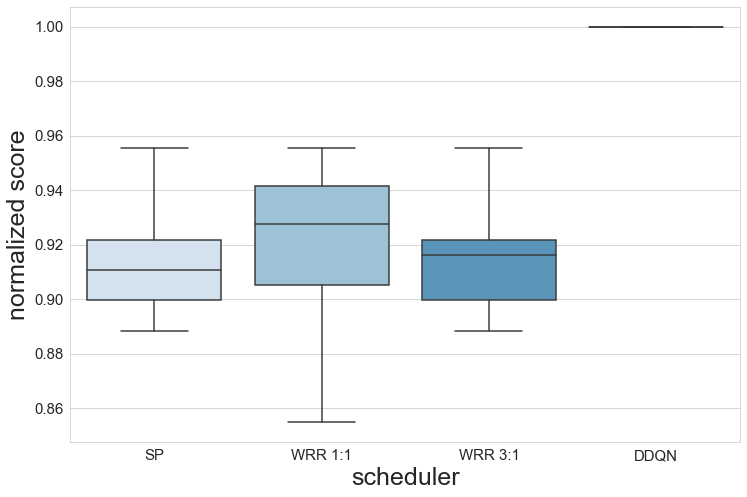

In [7]:
#wrr 1:1, 3:1
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

path = './test/single_optimum/'
# path = './test/'
dt = path + 'single_ddqn.csv'
st = path + 'SP/single_sp.csv'
rt1 = path + 'RR/single_rr.csv'
rt3 = path + 'RR/single_rr_3.csv'
 
dt = pd.read_csv(dt).drop('Unnamed: 0',axis = 1)
st = pd.read_csv(st).drop('Unnamed: 0',axis = 1)
rt1 = pd.read_csv(rt1).drop('Unnamed: 0',axis = 1)
rt3 = pd.read_csv(rt3).drop('Unnamed: 0',axis = 1)
st = st.drop(0, axis = 0)
dt = dt.drop(0, axis = 0)
rt1 = rt1.drop(0, axis = 0)
rt3 = rt3.drop(0, axis = 0)
dt_=list(dt['Score'])
st_=list(st['Score'])
rt1_ = list(rt1['Score'])
rt3_ = list(rt3['Score'])

score_list = dt_+st_+rt1_+rt3_
# max_ = np.max(score_list)
# min_ = np.min(score_list)
max_ = 44.8
min_ = 0
mm = max_ - min_
dt__ = list(map(lambda x : (x - min_)/mm, dt_))
st__ = list(map(lambda x : (x - min_)/mm, st_))
rt1__ = list(map(lambda x : (x - min_)/mm, rt1_))
rt3__ = list(map(lambda x : (x - min_)/mm, rt3_))


st.insert(0,'normalized score', st__)
st.insert(0,'scheduler', 'SP')
dt.insert(0,'normalized score', dt__)
dt.insert(0,'scheduler', 'DDQN')
rt1.insert(0,'normalized score', rt1__)
rt1.insert(0,'scheduler', 'WRR 1:1')
rt3.insert(0,'normalized score', rt3__)
rt3.insert(0,'scheduler', 'WRR 3:1')
data = pd.concat([st,rt1,rt3,dt])

plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
b = sns.boxplot(x="scheduler", y="normalized score", data = data, palette = "Blues")
# b.axes.set_title("Title",fontsize=10)
b.set_xlabel("scheduler",fontsize=25)
b.set_ylabel("normalized score",fontsize=25)
b.tick_params(labelsize=15)
# sns.plt.show()

# b = sns.boxplot()
# sns.set(rc = {'figure.figsize':(15,8)})
# sns.set(font_scale = 2.5)
# b = sns.boxplot(x=tips["total_bill"])
# b.axes.set_title("Title", fontsize=50)
# sns.set()
# sns.set_xlabel("scheduler", fontsize=20)
# sns.set_ylabel("normalized score", fontsize=20)
# sns.tick_params(labelsize=10)
# sns.boxplot(data = data)
plt.savefig('single node boxplot.png' ,dpi = 500)

## Comparing latency for each priority 

In [1]:
import sys
sys.path.append('/Users/jihye/src/Ryu project/TSN-with-DQN/ddqn')

import pandas as pd
import simpy
# from node import Node 
import time
import tensorflow as tf
# from parameter import *
# from src import Src

dt1 = 'test/single_optimum/single_delay1.csv'
dt2 = 'test/single_optimum/single_delay2.csv'
st1 = 'test/single_optimum/SP/single_delay1.csv'
st2 = 'test/single_optimum/SP/single_delay2.csv'
rt31 = 'test/single_optimum/RR/single_delay1_3.csv'
rt32 = 'test/single_optimum/RR/single_delay2_3.csv'
rt1 = 'test/single_optimum/RR/single_delay1.csv'
rt2 = 'test/single_optimum/RR/single_delay2.csv'

dt1_ = pd.read_csv(dt1)
dt2_ = pd.read_csv(dt2)
st1_ = pd.read_csv(st1)
st2_ = pd.read_csv(st2)
rt31_ = pd.read_csv(rt31)
rt32_ = pd.read_csv(rt32)
rt1_ = pd.read_csv(rt1)
rt2_ = pd.read_csv(rt2)

In [2]:
#qdelay_priority1
z1 = list(dt1_.iloc[:,1])
z2 = list(st1_.iloc[:,1])
z3 = list(rt1_.iloc[:,1])
z33 = list(rt31_.iloc[:,1])
#qdelay_priority2
z4 = list(dt2_.iloc[:,1])
z5 = list(st2_.iloc[:,1])
z6 = list(rt2_.iloc[:,1])
z36 = list(rt32_.iloc[:,1])

# z1_ = list(z1['qdelay'])
# z2_ = list(z2.sum(axis = 1))
# z3_ = list(z3.sum(axis = 1))
# z4_ = list(z4.sum(axis = 1))
# z5_ = list(z5.sum(axis = 1))
# z6_ = list(z6.sum(axis = 1))

In [3]:
def oper(ls):
    ls = list(map(lambda x:round(x*0.6,1), ls))
    return ls

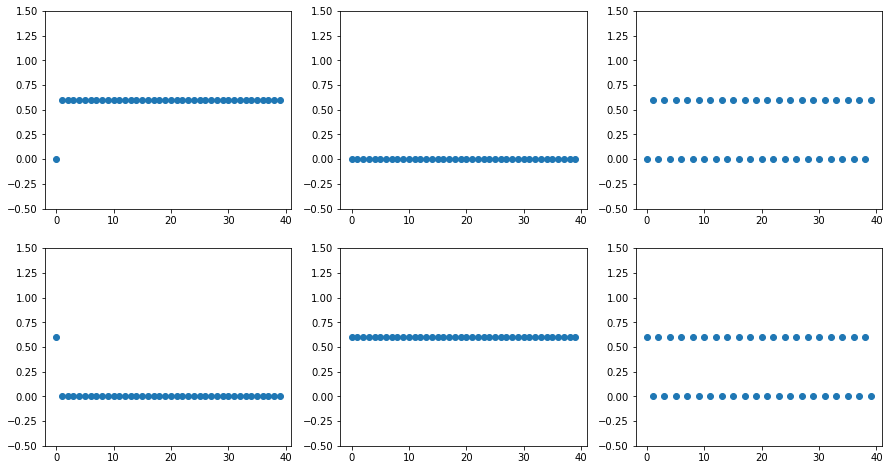

In [4]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(2,3)
f.set_size_inches((15,8))
plt.setp(axes, ylim = (-0.5,1.5))
axes[0][0].scatter(range(len(z1)),oper(z1))
axes[0][1].scatter(range(len(z2)),oper(z2))
axes[0][2].scatter(range(len(z3)),oper(z3))
axes[1][0].scatter(range(len(z4)),oper(z4))
axes[1][1].scatter(range(len(z5)),oper(z5))
axes[1][2].scatter(range(len(z6)),oper(z6))
plt.show()


In [5]:
x = []
x.append(list(dt1_.iloc[:,2]))
x.append(list(st1_.iloc[:,2]))
x.append(list(rt1_.iloc[:,2]))
x.append(list(rt31_.iloc[:,2]))
x.append(list(dt2_.iloc[:,2]))
x.append(list(st2_.iloc[:,2]))
x.append(list(rt2_.iloc[:,2]))
x.append(list(rt32_.iloc[:,2]))


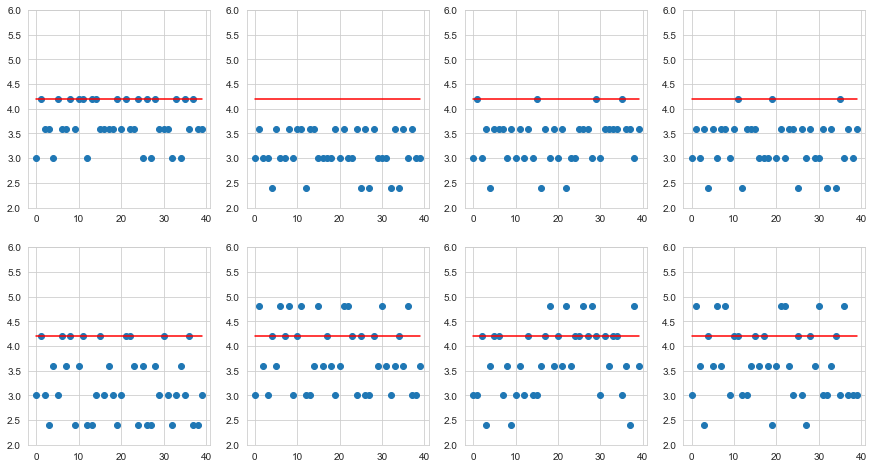

In [33]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(2,4)
f.set_size_inches((15,8))
plt.setp(axes, ylim = (2,6))


d=[7*0.6 for _ in range(len(x[0]))]

for i in range(2):
    for j in range(4):
#         plt.ylim(0,5)
        axes[i][j].scatter(range(len(x[(i*4)+j])), oper(x[(i*4)+j]))
        axes[i][j].plot(range(len(x[i+j])), d, c='red')
plt.show()
# plt.savefig('etdelay.png' ,dpi = 500)

#DDQN, SP, WRR(1:1), WRR(3:1) 순서

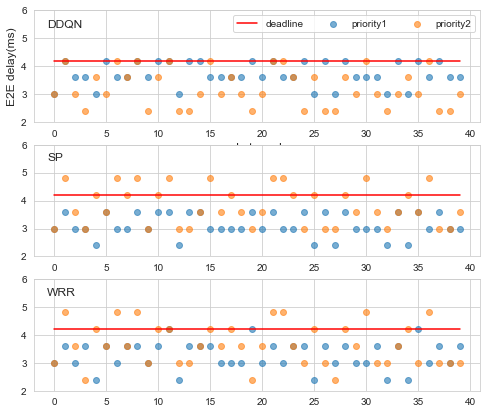

In [14]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(3,1)
f.set_size_inches((8,7))
plt.setp(axes, ylim = (2,6))


d=[7*0.6 for _ in range(len(x[0]))]
tt=['DDQN', 'SP', 'WRR']
for j in range(3):
    axes[j].set_title(tt[j],fontsize=12, loc='left', x=0.03, y=0.8)
    axes[0].set_xlabel('packet number', fontsize = 12)
    axes[0].set_ylabel('E2E delay(ms)', fontsize = 12)
    axes[j].scatter(range(len(x[j])), oper(x[j]),  alpha = .6, label = 'priority1')
    axes[j].scatter(range(len(x[j+3])), oper(x[j+3]),  alpha = .6, label = 'priority2')
    axes[j].plot(range(len(x[j])), d, c='red', label='deadline')
    axes[0].legend(ncol=3)
plt.savefig('etdelay.png' ,dpi = 500)    
plt.show()


In [6]:
import collections
DDQN1=collections.Counter(x[0])
DDQN2=collections.Counter(x[4])
print("DDQN ET: ",DDQN1, DDQN2)
SP1=collections.Counter(x[1])
SP2=collections.Counter(x[5])
print("SP ET: ", SP1, SP2)
WRR1=collections.Counter(x[2])
WRR2=collections.Counter(x[6])
print("WRR1 ET: ",WRR1, WRR2)
WRR31=collections.Counter(x[3])
WRR32=collections.Counter(x[7])
print("WRR3 ET: ",WRR31, WRR32)

DDQN ET:  Counter({6: 18, 7: 15, 5: 7}) Counter({5: 12, 4: 11, 7: 9, 6: 8})
SP ET:  Counter({5: 19, 6: 15, 4: 6}) Counter({5: 12, 6: 11, 8: 9, 7: 8})
WRR1 ET:  Counter({6: 20, 5: 13, 7: 4, 4: 3}) Counter({7: 13, 6: 10, 5: 9, 8: 5, 4: 3})
WRR3 ET:  Counter({6: 18, 5: 14, 4: 5, 7: 3}) Counter({5: 12, 6: 10, 7: 8, 8: 7, 4: 3})


(array([[ 0.,  0.,  0.,  7.,  0.,  0., 18.,  0.,  0., 15.],
        [ 6.,  0.,  0., 19.,  0.,  0., 15.,  0.,  0.,  0.],
        [ 5.,  0.,  0., 14.,  0.,  0., 18.,  0.,  0.,  3.]]),
 array([2.4 , 2.58, 2.76, 2.94, 3.12, 3.3 , 3.48, 3.66, 3.84, 4.02, 4.2 ]),
 <a list of 3 BarContainer objects>)

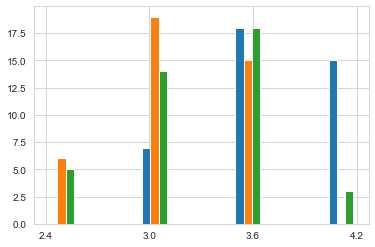

In [17]:
import matplotlib.pyplot as plt
s = [round(x*0.6,1) for x in range(8)]
plt.xticks(s,s)
# plt.xlim(2.4-0.5,4.2+0.5)
plt.hist((oper(x[0]),oper(x[1]), oper(x[2])),histtype='bar')
# plt.hist(oper(x[1]))
# plt.hist(oper(x[2]))

(array([[11.,  0., 12.,  0.,  0.,  8.,  0.,  9.,  0.,  0.],
        [11.,  0., 24.,  0.,  0., 19.,  0., 17.,  0.,  9.],
        [14.,  0., 36.,  0.,  0., 29.,  0., 25.,  0., 16.]]),
 array([2.4 , 2.64, 2.88, 3.12, 3.36, 3.6 , 3.84, 4.08, 4.32, 4.56, 4.8 ]),
 <a list of 3 BarContainer objects>)

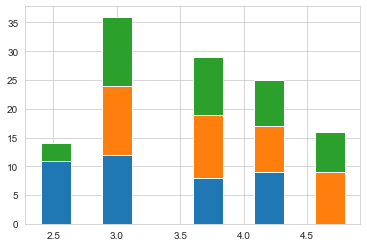

In [18]:
plt.hist((oper(x[3]),oper(x[4]), oper(x[5])),histtype='barstacked')

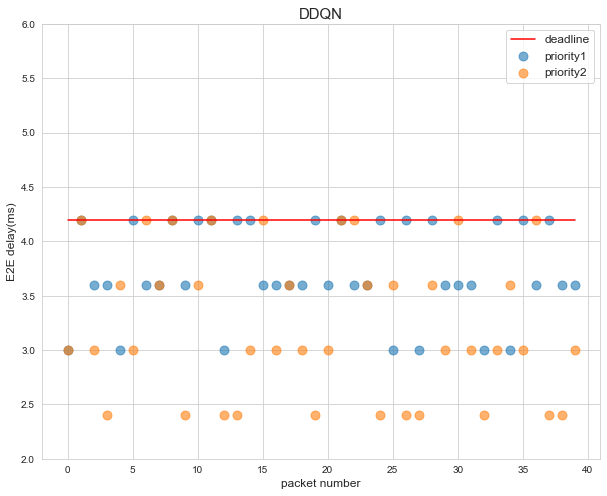

In [19]:

f, axes = plt.subplots(1,1)
f.set_size_inches((10,8))
plt.setp(axes, ylim = (2,6))


d=[7*0.6 for _ in range(len(x[0]))]
axes.set_title('DDQN',fontsize=15)
axes.set_xlabel('packet number', fontsize = 12)
axes.set_ylabel('E2E delay(ms)', fontsize = 12)

axes.scatter(range(len(x[0])), oper(x[0]),  alpha = .6, s=80, label = 'priority1')
axes.scatter(range(len(x[3])), oper(x[3]),  alpha = .6, s=80,label = 'priority2')
axes.plot(range(len(x[0])), d, c='red', label='deadline')
axes.legend(fontsize = 12)

# tt=['DDQN', 'SP', 'WRR']
# for j in range(3):
#     axes[j].set_title(tt[j],fontsize=12, loc='left', x=0.03, y=0.8)
#     axes[0].set_xlabel('packet number', fontsize = 12)
#     axes[0].set_ylabel('E2E delay(ms)', fontsize = 12)
#     axes[j].scatter(range(len(x[j])), oper(x[j]),  alpha = .6, label = 'priority1')
#     axes[j].scatter(range(len(x[j+3])), oper(x[j+3]),  alpha = .6, label = 'priority2')
#     axes[j].plot(range(len(x[j])), d, c='red', label='deadline')
#     axes[0].legend(ncol=3)
# plt.savefig('sdelayddqn.png' ,dpi = 500)    
plt.show()


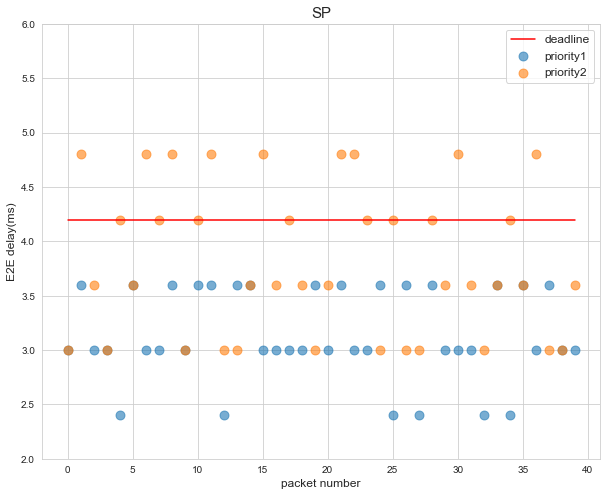

In [20]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(1,1)
f.set_size_inches((10,8))
plt.setp(axes, ylim = (2,6))


d=[7*0.6 for _ in range(len(x[0]))]
axes.set_title('SP',fontsize=15)
axes.set_xlabel('packet number', fontsize = 12)
axes.set_ylabel('E2E delay(ms)', fontsize = 12)

axes.scatter(range(len(x[1])), oper(x[1]),  alpha = .6, s=80, label = 'priority1')
axes.scatter(range(len(x[4])), oper(x[4]),  alpha = .6, s=80,label = 'priority2')
axes.plot(range(len(x[1])), d, c='red', label='deadline')
axes.legend(fontsize = 12)

# tt=['DDQN', 'SP', 'WRR']
# for j in range(3):
#     axes[j].set_title(tt[j],fontsize=12, loc='left', x=0.03, y=0.8)
#     axes[0].set_xlabel('packet number', fontsize = 12)
#     axes[0].set_ylabel('E2E delay(ms)', fontsize = 12)
#     axes[j].scatter(range(len(x[j])), oper(x[j]),  alpha = .6, label = 'priority1')
#     axes[j].scatter(range(len(x[j+3])), oper(x[j+3]),  alpha = .6, label = 'priority2')
#     axes[j].plot(range(len(x[j])), d, c='red', label='deadline')
#     axes[0].legend(ncol=3)
# plt.savefig('sdelaysp.png' ,dpi = 500)    
plt.show()


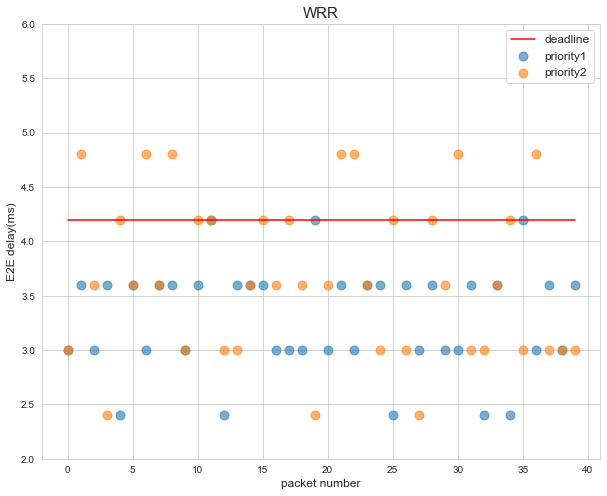

In [21]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(1,1)
f.set_size_inches((10,8))
plt.setp(axes, ylim = (2,6))


d=[7*0.6 for _ in range(len(x[0]))]
axes.set_title('WRR',fontsize=15)
axes.set_xlabel('packet number', fontsize = 12)
axes.set_ylabel('E2E delay(ms)', fontsize = 12)

axes.scatter(range(len(x[2])), oper(x[2]),  alpha = .6, s=80, label = 'priority1')
axes.scatter(range(len(x[5])), oper(x[5]),  alpha = .6, s=80,label = 'priority2')
axes.plot(range(len(x[1])), d, c='red', label='deadline')
axes.legend(fontsize = 12)

# tt=['DDQN', 'SP', 'WRR']
# for j in range(3):
#     axes[j].set_title(tt[j],fontsize=12, loc='left', x=0.03, y=0.8)
#     axes[0].set_xlabel('packet number', fontsize = 12)
#     axes[0].set_ylabel('E2E delay(ms)', fontsize = 12)
#     axes[j].scatter(range(len(x[j])), oper(x[j]),  alpha = .6, label = 'priority1')
#     axes[j].scatter(range(len(x[j+3])), oper(x[j+3]),  alpha = .6, label = 'priority2')
#     axes[j].plot(range(len(x[j])), d, c='red', label='deadline')
#     axes[0].legend(ncol=3)
# plt.savefig('sdelaywrr.png' ,dpi = 500)    
plt.show()


## Delay graph with deadline

In [7]:
def dictsort(rng, counter):
    dct = dict(counter)
    
    for r in rng:
        if not r in dct:
            dct.update({r:0})
        
    d = dict(sorted(dct.items()))
    key = list(d.keys())
    value = list(d.values())
    
    return oper(key), value

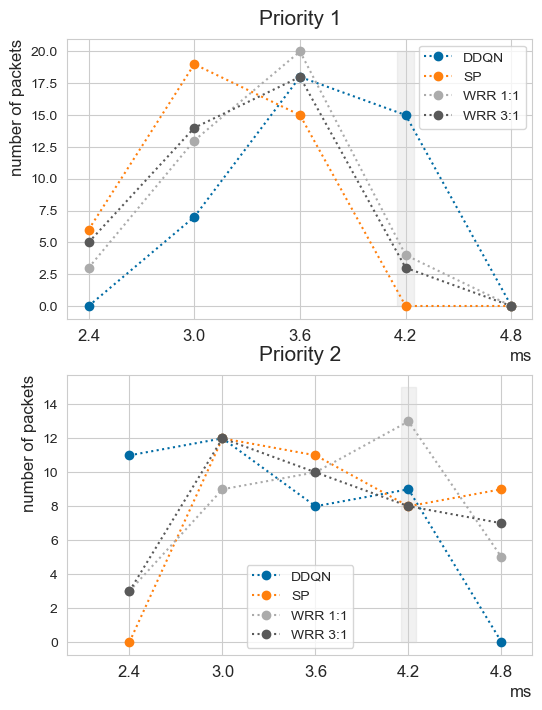

In [67]:
## import matplotlib.pyplot as plt
rang = [4,5,6,7,8]
import seaborn as sns


_DDQN1=dictsort(rang,DDQN1)
_DDQN2=dictsort(rang,DDQN2)
_SP1=dictsort(rang,SP1)
_SP2=dictsort(rang,SP2)
_WRR1=dictsort(rang,WRR1)
_WRR31=dictsort(rang,WRR31)
_WRR2=dictsort(rang,WRR2)
_WRR32=dictsort(rang,WRR32)

f, axes = plt.subplots(2,1)
f.set_size_inches((6,8))
# plt.setp(axes, ylim = (2,6))
plt.xlim((2,5))
# plt.style.use('default')
sns.set_style('whitegrid')
plt.style.use('tableau-colorblind10')

axes[0].set_title('Priority 1',fontsize=15,pad=10)
axes[0].set_xlabel('ms', fontsize = 12, loc='right')
axes[0].set_ylabel('number of packets', fontsize = 12, loc='top')
axes[0].set_xticks(_DDQN1[0])
axes[0].tick_params(axis='x',labelsize=12)

axes[0].plot(_DDQN1[0],_DDQN1[1],marker='o',linestyle=':')
axes[0].plot(_SP1[0],_SP1[1],marker='o',linestyle=':')
axes[0].plot(_WRR1[0],_WRR1[1],marker='o',linestyle=':')
axes[0].plot(_WRR31[0],_WRR31[1],marker='o',linestyle=':')
axes[0].legend(['DDQN','SP','WRR 1:1','WRR 3:1'])
axes[0].fill([4.15,4.15,4.25,4.25], [20, 0, 0, 20], color='lightgray', alpha=0.3)
# axes[0].text(4.05, 18, 'deadline', fontsize = 14)



axes[1].set_title('Priority 2',fontsize=15,pad=10)
axes[1].set_xlabel('ms', fontsize = 12, loc='right')
axes[1].set_ylabel('number of packets', fontsize = 12, loc='top')
axes[1].set_xticks(_DDQN1[0])
axes[1].tick_params(axis='x',labelsize=12)

axes[1].plot(_DDQN2[0],_DDQN2[1],marker='o',linestyle=':')
axes[1].plot(_SP2[0],_SP2[1],marker='o',linestyle=':')
axes[1].plot(_WRR2[0],_WRR2[1],marker='o',linestyle=':')
axes[1].plot(_WRR32[0],_WRR32[1],marker='o',linestyle=':')
axes[1].legend(['DDQN','SP','WRR 1:1','WRR 3:1'])
axes[1].fill([4.15,4.15,4.25,4.25], [15, 0, 0, 15], color='lightgray', alpha=0.3)


# d=[7*0.6 for _ in range(len(x[0]))]

# for i in range(2):
#     for j in range(4):
# #         plt.ylim(0,5)
#         axes[i][j].scatter(range(len(x[(i*4)+j])), oper(x[(i*4)+j]))
#         axes[i][j].plot(range(len(x[i+j])), d, c='red')
# plt.style.use(st[2])

plt.savefig('etdelay.png' ,dpi = 500)

plt.show()

#DDQN, SP, WRR(1:1), WRR(3:1) 순서